#Step 0: Get Data and Imports



In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download brunovr/avatar-the-last-airbender-complete-transcript -f ATLA-episodes-scripts.csv

  0% 0.00/674k [00:00<?, ?B/s]
100% 674k/674k [00:00<00:00, 83.0MB/s]


In [5]:
!python -m spacy download en_core_web_md

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-31 17:32:04.086481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 17:32:09.419539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-03-31 17:32:14.343477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package

In [6]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Step 1: Quick Look at the Data

In [7]:
# Load dataset into pandas DataFrame
df = pd.read_csv("ATLA-episodes-scripts.csv.zip",
                 header=0,
                 names=["character", "raw_text", "book_ep_number", "book", "series_ep_number"])

In [8]:
df.head()

,character,raw_text,book_ep_number,book,series_ep_number
0,NaN,"As the title card fades, the scene opens onto ...",1,1,1
1,Sokka,It's not getting away from me this time. [Clos...,1,1,1
2,NaN,"The shot pans quickly from Sokka to Katara, wh...",1,1,1
3,Katara,"[Happily surprised.] Sokka, look!",1,1,1
4,Sokka,"[Close-up of Sokka; whispering.] Sshh! Katara,...",1,1,1


In [9]:
# Null values in ["character"] column indicate the text is a description and not a line.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13369 entries, 0 to 13368
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   character         9977 non-null   object
 1   raw_text          13369 non-null  object
 2   book_ep_number    13369 non-null  int64 
 3   book              13369 non-null  int64 
 4   series_ep_number  13369 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 522.4+ KB


In [10]:
# Reduce DataFrame to character lines (only rows with a non-null value in ["character"] column)
lines_df = df.loc[df['character'].notnull()].reset_index(drop=True)

In [11]:
lines_df.head()

,character,raw_text,book_ep_number,book,series_ep_number
0,Sokka,It's not getting away from me this time. [Clos...,1,1,1
1,Katara,"[Happily surprised.] Sokka, look!",1,1,1
2,Sokka,"[Close-up of Sokka; whispering.] Sshh! Katara,...",1,1,1
3,Katara,[Struggling with the water that passes right i...,1,1,1
4,Katara,[Exclaims indignantly.] Hey!,1,1,1


In [12]:
# No more null values
lines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9977 entries, 0 to 9976
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   character         9977 non-null   object
 1   raw_text          9977 non-null   object
 2   book_ep_number    9977 non-null   int64 
 3   book              9977 non-null   int64 
 4   series_ep_number  9977 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 389.9+ KB


# Step 2: Dive Into Character Column

In [13]:
# There are 374 unique character names
lines_df["character"].value_counts()

Aang                1795
Sokka               1635
Katara              1428
Zuko                 776
Toph                 507
                    ... 
Star                   1
Third girl             1
Boy's mother           1
Guard #2               1
Katara and Sokka       1
Name: character, Length: 374, dtype: int64

After searching through a value_counts() of the character column, I found that some characters are listed twice under different names. I will clean the column to exclude rank/titles so each character is in there once.

In [14]:
def clean_characters(text: str):
  '''
  Removes characters from a string that ar not alphanumeric or whitespace.
  Removes common titles from a string.

  Parameters
  ----------
  text: string
    raw character name

  Returns
  -------
  text: string
    cleaned character name
  '''
  # Remove characters that are not alphanumeric or whitespace
  text = re.sub(r"[^0-9A-Za-z ]", " ", text)
  # Remove titles
  text = text.replace("King", " ")
  text = text.replace("Great", " ")
  text = text.replace("of the", "of ")
  text = text.replace("General", " ")
  text = text.replace("Avatar", " ")
  text = text.replace("Lieutenant", " ")
  text = text.replace("Princess", " ")
  # Remove multiple whitespaces
  text = re.sub(r"\s+", " ", text)

  text = text.title().strip()
  return text

lines_df['character'] = lines_df['character'].apply(clean_characters)

In [15]:
# There are 360 different values after cleaning
lines_df["character"].value_counts()

Aang                 1796
Sokka                1635
Katara               1428
Zuko                  776
Toph                  507
                     ... 
Scout 1                 1
Earthbender Guard       1
Student                 1
Terra Team Leader       1
Katara And Sokka        1
Name: character, Length: 360, dtype: int64

Now I will create a new DataFrame with information about each character.

In [16]:
character_dict = {}

In [17]:
characters = []
for character in lines_df["character"].value_counts().index:
  characters.append(character)
character_dict["character"] = characters

In [18]:
total_episodes = []
for character in character_dict["character"]:
  count = 0
  seen = []
  for episode in lines_df.loc[lines_df["character"] == character]["series_ep_number"]:
    if episode not in seen:
      seen.append(episode)
      count += 1
  total_episodes.append(count)
character_dict["total_episodes"] = total_episodes

In [19]:
character_dict["total_lines"] = list(lines_df["character"].value_counts())

In [20]:
character_df = pd.DataFrame(character_dict)
character_df.head()

,character,total_episodes,total_lines
0,Aang,60,1796
1,Sokka,59,1635
2,Katara,59,1428
3,Zuko,47,776
4,Toph,35,507


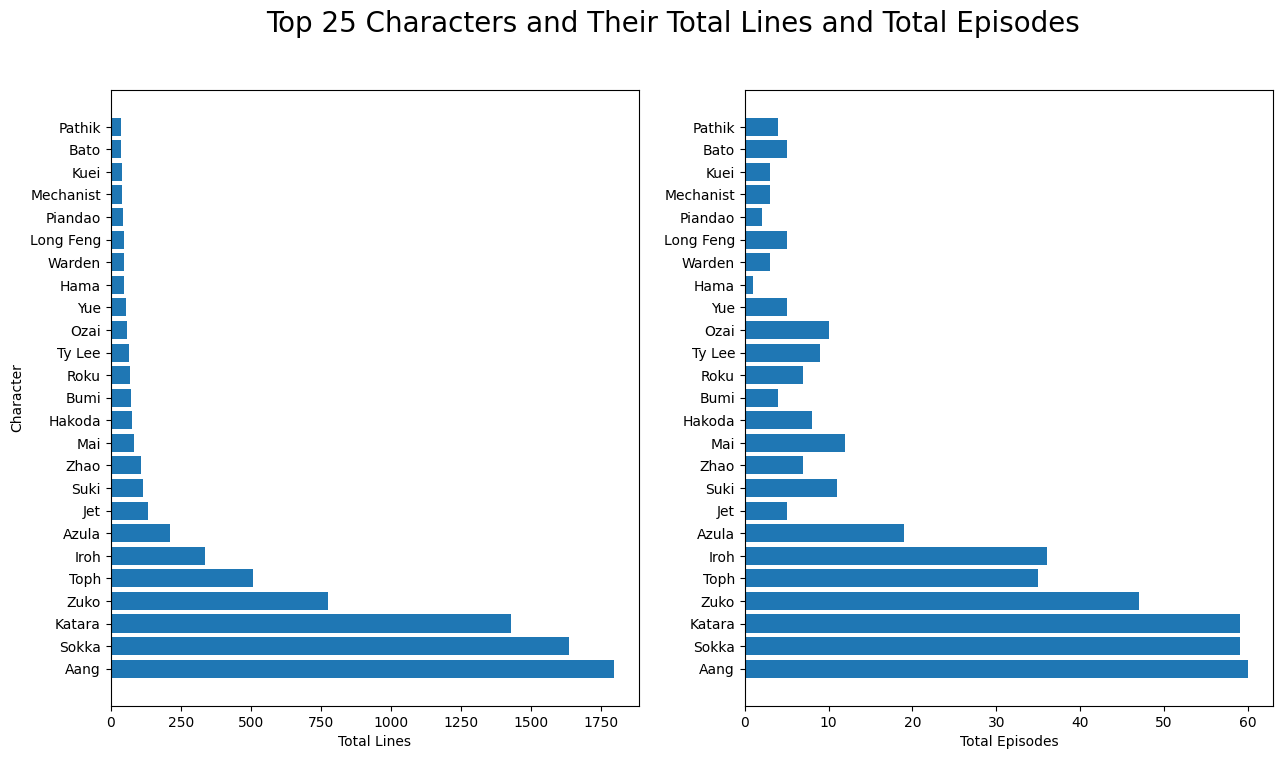

In [21]:
# Visualize top 25 characters
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
plt.suptitle("Top 25 Characters and Their Total Lines and Total Episodes", fontsize=20)

ax[0].barh(character_df["character"][:25], character_df["total_lines"][:25])
ax[0].set_xlabel("Total Lines")
ax[0].set_ylabel("Character")

ax[1].barh(character_df["character"][:25], character_df["total_episodes"][:25])
ax[1].set_xlabel("Total Episodes")

plt.show()

The above graphs display the characters in the same order. We can see that Total Number of Lines and Total Number of Episodes show a similar trend.

Now I will just look at the main characters which I have defined as Aang, Katara, Sokka, Toph, Zuko, and Iroh. I want to see how their percent of lines changes over each season.

In [22]:
# Since Toph did not appear in Season 1, the for-loop did not work on her so I 
# ended up hard-coding her values.
percent_lines_season = {}
lines_per_season = list(lines_df.groupby("book").count()["raw_text"])
main_characters = ["Aang", "Katara", "Sokka", "Zuko", "Iroh"]
for character in main_characters:
  percent_lines_season[f"{character}"] = list(
      lines_df.loc[lines_df["character"]== f"{character}"]
      .groupby("book").count()["raw_text"] / lines_per_season * 100)
percent_lines_season["Toph"] = [0, 7.60, 8.02]

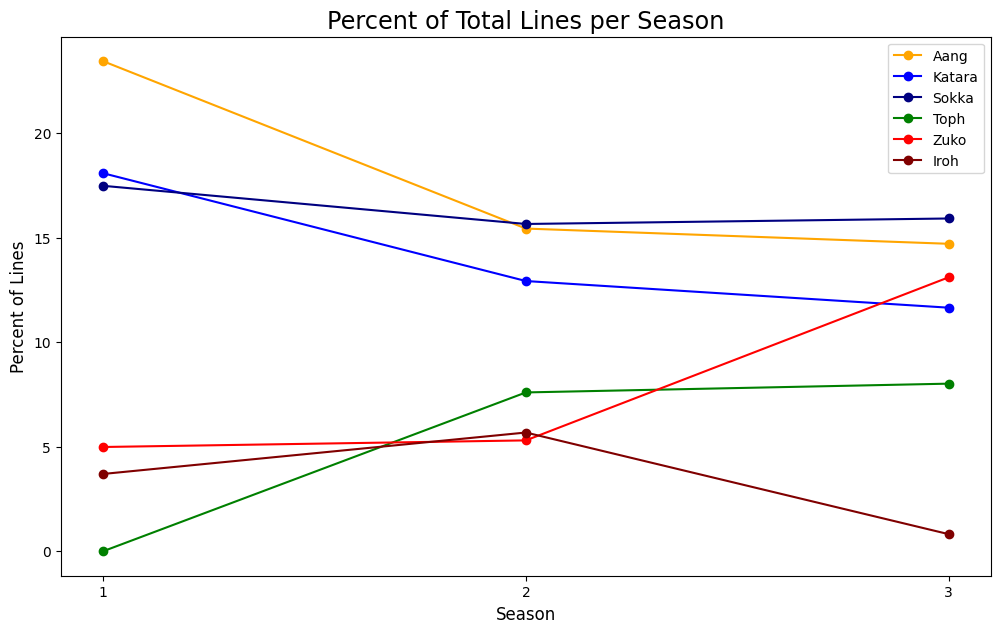

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_xticks([0, 1, 2],labels=[1, 2, 3])
plt.title("Percent of Total Lines per Season", fontsize="xx-large")
plt.xlabel("Season", fontsize="large")
plt.ylabel("Percent of Lines", fontsize="large")

plt.plot(percent_lines_season["Aang"],
         color="orange",
         marker="o",
         label="Aang")
plt.plot(percent_lines_season["Katara"],
         color="blue",
         marker="o",
         label="Katara")
plt.plot(percent_lines_season["Sokka"],
         color="navy",
         marker="o",
         label="Sokka")
plt.plot(percent_lines_season["Toph"],
         color="green",
         marker="o",
         label="Toph")
plt.plot(percent_lines_season["Zuko"],
         color="red",
         marker="o",
         label="Zuko")
plt.plot(percent_lines_season["Iroh"],
         color="maroon",
         marker="o",
         label="Iroh")

ax.legend()

plt.show()

The characters' percentages get much closer together throughout the seasons(excluding Iroh as he is gone from much of the third season). This goes with the characters' arcs in the show, as Toph and Zuko become part of the team, the rest of the team must balance out their lines.

# Step 3: Clean Text Column

In [24]:
# Preview first few lines
lines_df['raw_text'][0]

"It's not getting away from me this time. [Close-up of Sokka as he grins confidently over his shoulder in the direction of Katara.] Watch and learn, Katara. This is how you catch a fish."

In addition to usual text cleaning techniques, I will need to remove text within square brackets because this indicates direction and not spoken lines.

In [25]:
def clean_text(text:str):
  '''
  Takes raw text and cleans it.

  Parameters
  ----------
  text: str
    raw text

  Returns
  -------
  text: str
    cleaned text
  '''
  
  # Replace text within brackets with white-space
  text = re.sub(r"\[(.*?)\]", " ", text)

  # Remove non-alpha
  text = re.sub(r"[^a-zA-Z ]", "", text)

  # Remove extra white-space
  text = re.sub("\s+"," ",text)

  return text.lower().strip()

lines_df["clean_text"] = lines_df["raw_text"].apply(clean_text)

In [26]:
# Take a look at the DataFrame
lines_df.head()

,character,raw_text,book_ep_number,book,series_ep_number,clean_text
0,Sokka,It's not getting away from me this time. [Clos...,1,1,1,its not getting away from me this time watch a...
1,Katara,"[Happily surprised.] Sokka, look!",1,1,1,sokka look
2,Sokka,"[Close-up of Sokka; whispering.] Sshh! Katara,...",1,1,1,sshh katara youre going to scare it away mmmm ...
3,Katara,[Struggling with the water that passes right i...,1,1,1,but sokka i caught one
4,Katara,[Exclaims indignantly.] Hey!,1,1,1,hey


Now I want to tokenize and get the lemmas of the text.

In [27]:
nlp = spacy.load("en_core_web_md")

In [28]:
def tokenizer(text):
  '''
  Uses spaCy to tokenize and get lemmas of text.

  Parameters
  ----------
  text: str
    text to be tokenized

  Returns
  -------
  tokens: list of strings
  '''
  doc = nlp(text)
  tokens = [token.lemma_ for token in doc if ((not token.is_stop) &
                                              (not token.is_space) &
                                              (len(token) > 2))]
  return tokens

lines_df["lemmas"] = lines_df["clean_text"].apply(tokenizer)

In [29]:
lines_df.head()

,character,raw_text,book_ep_number,book,series_ep_number,clean_text,lemmas
0,Sokka,It's not getting away from me this time. [Clos...,1,1,1,its not getting away from me this time watch a...,"[get, away, time, watch, learn, katara, catch,..."
1,Katara,"[Happily surprised.] Sokka, look!",1,1,1,sokka look,"[sokka, look]"
2,Sokka,"[Close-up of Sokka; whispering.] Sshh! Katara,...",1,1,1,sshh katara youre going to scare it away mmmm ...,"[sshh, katara, go, scare, away, mmmm, smell, c..."
3,Katara,[Struggling with the water that passes right i...,1,1,1,but sokka i caught one,"[sokka, catch]"
4,Katara,[Exclaims indignantly.] Hey!,1,1,1,hey,[hey]


# Step 4: Count Vectorizer

I want to look at the overall token frequency and the token frequency for each of the main characters.

In [30]:
# I will use this function to override the preproccessing and tokenizing in the
# vectorizer since I have already completed those steps.
def dummy_func(doc):
  '''
  Dummy function to return the input.

  Parameters
  ----------
  doc

  Returns
  -------
  doc
  '''
  
  return doc

In [31]:
# Use CountVectorizer to find the most common words
# and look at the document-term-matrix
vect = CountVectorizer(preprocessor=dummy_func,
                       tokenizer=dummy_func,
                       token_pattern=None,
                       min_df=2,
                       max_df=.8)
vect.fit(lines_df["lemmas"])
dtm_tf = vect.transform(lines_df["lemmas"])
dtm_tf = pd.DataFrame(dtm_tf.todense(), columns=vect.get_feature_names_out())
dtm_tf

,aaaah,aaah,aaahhh,aah,aahh,aang,aangs,aangy,abandon,abbey,...,yum,yup,yuyan,zei,zhang,zhao,zoo,zuko,zukos,zuzu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


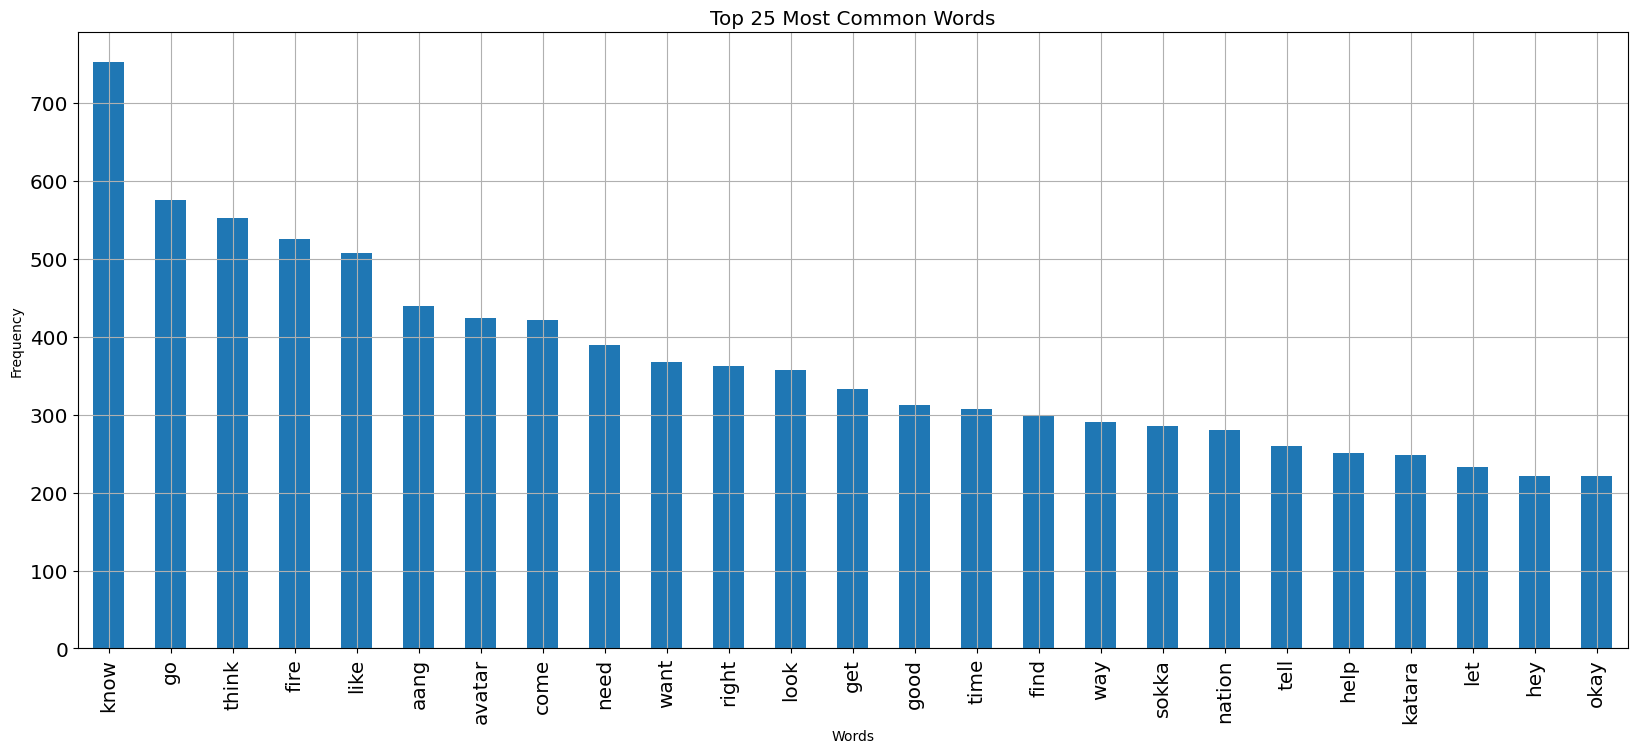

In [32]:
# Visualize most common words
sorted_terms = dtm_tf.sum().sort_values(ascending=False)

plt.title("Top 25 Most Common Words", fontsize="x-large")
plt.xlabel("Words")
plt.ylabel("Frequency")
sorted_terms[:25].plot(kind="bar", figsize=(20,8), grid=True, fontsize="x-large")

plt.show()

In [33]:
def vect_transform(vect, character: str):
  '''
  Transforms a given character's documents to document-term-matrix using a fit vectorizer.

  Parameters
  ----------
  vect:
    fit vectorizer

  character: str
    the character whose documents are to be transformed

  Returns
  -------
  sorted_terms: pandas Series
    document-term-matrix sorted in descending order
  '''
  dtm_tf = vect.transform(lines_df["lemmas"].loc[lines_df["character"] == f"{character}"])
  dtm_tf = pd.DataFrame(dtm_tf.todense(), columns=vect.get_feature_names_out())
  sorted_terms = dtm_tf.sum().sort_values(ascending=False)

  return sorted_terms

In [34]:
# Create the dtm's for each character
sorted_terms_aang = vect_transform(vect, "Aang")
sorted_terms_katara = vect_transform(vect, "Katara")
sorted_terms_sokka = vect_transform(vect, "Sokka")
sorted_terms_toph = vect_transform(vect, "Toph")
sorted_terms_zuko = vect_transform(vect, "Zuko")
sorted_terms_iroh = vect_transform(vect, "Iroh")

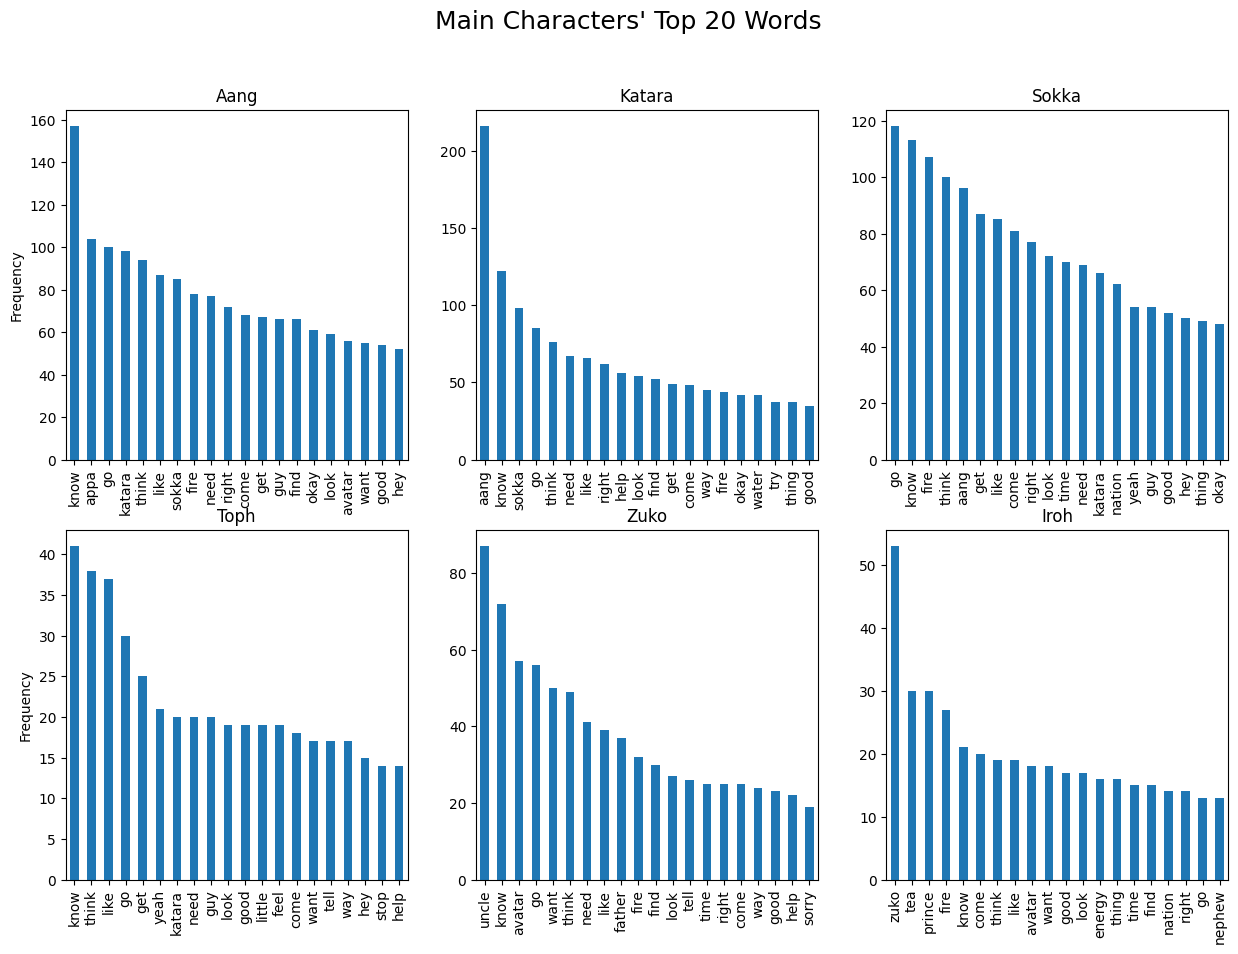

In [35]:
# Visualize top 20 words for each character
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle("Main Characters' Top 20 Words", fontsize=18)

sorted_terms_aang[:20].plot(kind="bar", ax=ax[0][0], fontsize=10)
ax[0][0].set_title("Aang")
ax[0][0].set_ylabel("Frequency")

sorted_terms_katara[:20].plot(kind="bar", ax=ax[0][1], fontsize=10)
ax[0][1].set_title("Katara")

sorted_terms_sokka[:20].plot(kind="bar", ax=ax[0][2], fontsize=10)
ax[0][2].set_title("Sokka")

sorted_terms_toph[:20].plot(kind="bar", ax=ax[1][0], fontsize=10)
ax[1][0].set_title("Toph")
ax[1][0].set_ylabel("Frequency")

sorted_terms_zuko[:20].plot(kind="bar", ax=ax[1][1], fontsize=10)
ax[1][1].set_title("Zuko")

sorted_terms_iroh[:20].plot(kind="bar", ax=ax[1][2], fontsize=10)
ax[1][2].set_title("Iroh")

plt.show()

**Observations**



*   One of the top words for each character is a name which shows who they have strong relationships with.
*   Zuko and Iroh are a heart-warming uncle-nephew duo. Zuko's top word is "uncle" and Iroh's is "zuko". 🥰
*   It is extremely on brand that Iroh's most common words are "zuko" and "tea" as they are essential to his his character. ☕
*   It is a running joke in the show that Zuko is obsessed with his honor, especially in the first season. Since "honor" wasn't one of his top 20 overall words, I wanted to see if it was one of his top words in season 1.

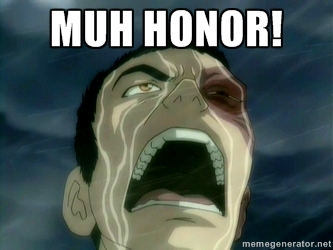

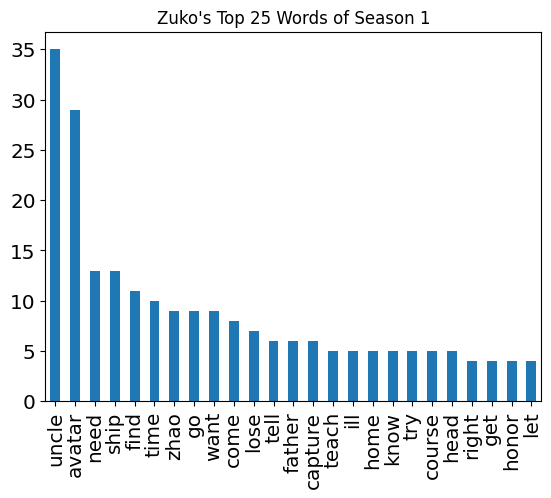

In [36]:
# Visualize Zuko's top words in Season 1
dtm_tf_zuko_s1 = vect.transform(lines_df["lemmas"].loc[(lines_df["character"] == "Zuko") & (lines_df["book"] == 1)])
dtm_tf_zuko_s1 = pd.DataFrame(dtm_tf_zuko_s1.todense(), columns=vect.get_feature_names_out())
sorted_terms_zuko_s1 = dtm_tf_zuko_s1.sum().sort_values(ascending=False)
sorted_terms_zuko_s1[:25].plot(kind="bar", fontsize="x-large")

plt.title("Zuko's Top 25 Words of Season 1")

plt.show()

"Honor" still was not one of his top 20 in season 1 but it was his 24th!

# Step 5: Td-idf Vectorizer

Using the count vectorizer, the characters had a lot of crossover of their top words. I will use a tfidf vectorizer to factor in the uniqueness of a word to a character. For this case, each document will be all of the lines of a given character.

In [37]:
main_characters = ['Aang', 'Katara', 'Sokka', 'Toph', 'Zuko', 'Iroh']

In [38]:
# Create the corpus to fit the vectorizer on
corpus = [[lemma for lemmas in lines_df.loc[lines_df["character"] == character]["lemmas"] for lemma in lemmas] for character in main_characters]

len(corpus)

6

In [39]:
tfidf_vect = TfidfVectorizer(preprocessor=dummy_func,
                             tokenizer=dummy_func,
                             token_pattern=None)
tfidf_vect.fit(corpus)
dtm_tfidf = tfidf_vect.transform(corpus)
dtm_tfidf = pd.DataFrame(dtm_tfidf.todense(), columns=tfidf_vect.get_feature_names_out(), index=main_characters)
dtm_tfidf

,aaaaah,aaaaahh,aaaachoo,aaaah,aaah,aaahhh,aackackbleck,aah,aahh,aang,...,zero,zhang,zhao,zhaos,zigzag,zone,zookeeper,zuko,zukos,zuzu
Aang,0.000000,0.000000,0.004692,0.003847,0.000000,0.003847,0.000000,0.004692,0.000000,0.014578,...,0.004692,0.007694,0.009614,0.000000,0.004692,0.000000,0.004692,0.043734,0.000000,0.004692
Katara,0.005372,0.000000,0.000000,0.000000,0.004405,0.000000,0.005372,0.000000,0.000000,0.515057,...,0.000000,0.008810,0.002752,0.000000,0.000000,0.000000,0.000000,0.042921,0.003719,0.000000
Sokka,0.000000,0.004962,0.000000,0.000000,0.004069,0.004069,0.000000,0.000000,0.008138,0.211458,...,0.000000,0.000000,0.005084,0.000000,0.000000,0.004962,0.000000,0.046256,0.003435,0.000000
Toph,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075617,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034372,0.000000,0.000000
Zuko,0.000000,0.000000,0.000000,0.007660,0.000000,0.000000,0.000000,0.000000,0.000000,0.037321,...,0.000000,0.000000,0.043074,0.009342,0.000000,0.000000,0.000000,0.020734,0.000000,0.000000
Iroh,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012989,0.007031,...,0.000000,0.000000,0.064923,0.000000,0.000000,0.000000,0.000000,0.372666,0.010966,0.000000


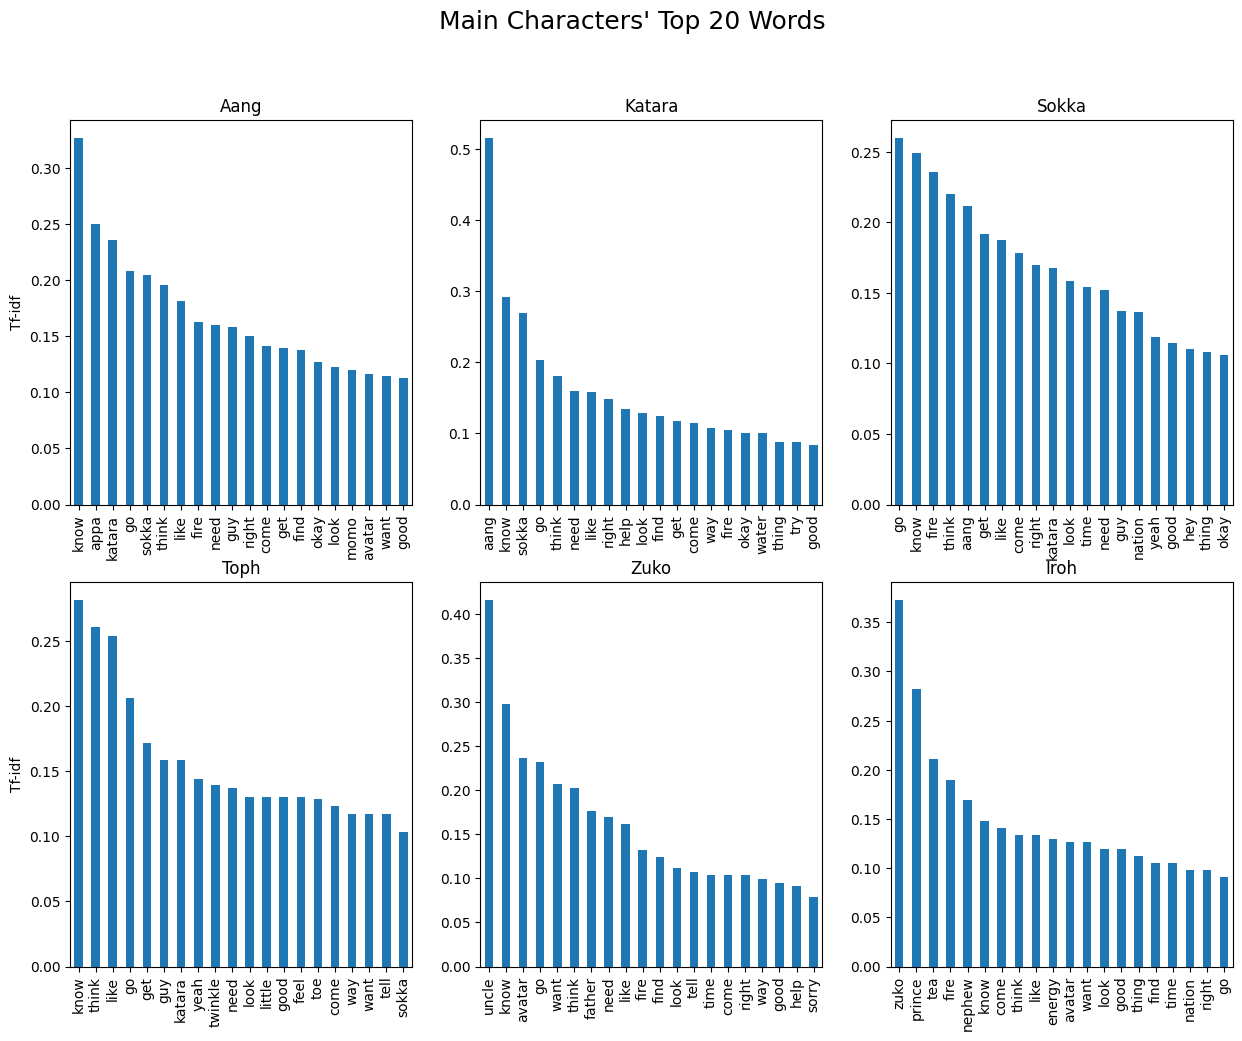

In [41]:
# Visualize top 20 words for each character
fig, ax = plt.subplots(2, 3, figsize=(15, 11))
plt.suptitle("Main Characters' Top 20 Words", fontsize=18)

dtm_tfidf.T["Aang"].sort_values(ascending=False)[:20].plot(kind="bar", ax=ax[0][0], fontsize=10)
ax[0][0].set_title("Aang")
ax[0][0].set_ylabel("Tf-idf")

dtm_tfidf.T["Katara"].sort_values(ascending=False)[:20].plot(kind="bar", ax=ax[0][1], fontsize=10)
ax[0][1].set_title("Katara")

dtm_tfidf.T["Sokka"].sort_values(ascending=False)[:20].plot(kind="bar", ax=ax[0][2], fontsize=10)
ax[0][2].set_title("Sokka")

dtm_tfidf.T["Toph"].sort_values(ascending=False)[:20].plot(kind="bar", ax=ax[1][0], fontsize=10)
ax[1][0].set_title("Toph")
ax[1][0].set_ylabel("Tf-idf")

dtm_tfidf.T["Zuko"].sort_values(ascending=False)[:20].plot(kind="bar", ax=ax[1][1], fontsize=10)
ax[1][1].set_title("Zuko")

dtm_tfidf.T["Iroh"].sort_values(ascending=False)[:20].plot(kind="bar", ax=ax[1][2], fontsize=10)
ax[1][2].set_title("Iroh")

plt.show()

**Observations**


*   They still have a fair amount of the same words but now have a few more terms that are somewhat unique to the character.
*   Two of Toph's top terms are "twinkle" and "toe" and her nickname for Aang is "Twinkle Toes".

**Future Ideas**


*   Build model to predict which character is more likely to have said a given line
*   Visualize the distribution of of characters in each nation
*   Sentiment Analysis for main characters







